In [1]:
import pandas as pd
import numpy as np
import configparser
config = configparser.ConfigParser()

config.read("../final_project_files/env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [2]:
OHCO = ['book_title','chap_num', 'para_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)

In [3]:
CORPUS = pd.read_csv(f"{output_dir}\\CORPUS.csv").set_index(OHCO)
CORPUS.head()

token_str term_str  \
book_title           chap_num para_num sent_num token_num                      
01_a_game_of_thrones 1        0        1        1                We       we   
                                                2            should   should   
                                                3             start    start   
                                                4              back     back   
                                                7             Gared    gared   

                                                           pos pos_group  
book_title           chap_num para_num sent_num token_num                 
01_a_game_of_thrones 1        0        1        1          PRP        PR  
                                                2           MD        MD  
                                                3           VB        VB  
                                                4           RP        RP  
                                                7          VBD        VB

### BOW

In [4]:
def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

### TFIDF

In [5]:
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF, DTCM

### Using Fuctions

In [6]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['max_pos'] = CORPUS.value_counts(['term_str','pos']).unstack().idxmax(1)
VOCAB.head()

,n,max_pos
term_str,,
the,157913,DT
and,74625,CC
to,65973,TO
a,62275,DT
of,56741,IN


In [7]:
bag = bags['BOOKS']
BOW = create_bow(CORPUS, bag)
TFIDF, DFIDF, DTM = get_tfidf(BOW, tf_method='log', df_method='sklearn_smooth')

In [8]:
VOCAB['dfidf'] = DFIDF
VOCAB['mean_tfidf'] = TFIDF.mean()

In [9]:
VOCAB.head(2)

,n,max_pos,dfidf,mean_tfidf
term_str,,,,
the,157913,DT,18.0,12.667898
and,74625,CC,18.0,11.492454


In [10]:
TFIDF[VOCAB.sort_values('n', ascending=False).head(200).sample(10).index].sample(10).fillna(0).style.background_gradient(cmap='GnBu', high=.75)

term_str,this,know,cat,too,s,you,out,us,from,go
book_title,,,,,,,,,,
04_a_feast_for_crows,9.497852,8.891784,6.392317,8.997179,11.593858,11.770251,9.090112,8.636625,10.224002,7.960002
04_fire_star,8.864186,7.375039,4.700440,6.087463,9.923327,10.016808,8.357552,5.781360,8.495855,6.491853
01_a_game_of_thrones,9.445015,8.738092,5.285402,8.531381,11.406205,11.770664,9.507795,8.247928,10.274960,8.209453
01_the_fire_within,6.988685,6.339850,5.727920,5.129283,9.815383,9.366322,7.531381,3.584963,7.409391,6.643856
03_a_storm_of_swords,10.000000,9.440869,5.000000,9.471675,12.141469,12.400346,9.743151,8.982994,10.676839,8.751544
06_fire_world,9.139551,7.614710,1.000000,6.209453,10.011227,10.279611,8.317413,6.882643,8.679480,7.044394
01_into_the_wild,7.636625,6.475733,7.303781,6.442943,9.370687,9.643856,7.918863,6.129283,8.262095,6.266787
07_the_fire_ascending,9.063395,7.781360,4.321928,6.614710,10.055282,10.358651,8.379378,7.098032,8.897845,6.894818
03_the_fire_eternal,8.710806,7.149747,5.285402,6.266787,10.007027,10.007027,8.087463,6.000000,8.366322,6.569856


In [11]:
bag2 = bags['CHAPS']
BOW2 = create_bow(CORPUS, bag2)
TFIDF2, DFIDF2, DTM2 = get_tfidf(BOW2, tf_method='log', df_method='sklearn_smooth')

In [12]:
VOCAB2 = VOCAB.copy()
VOCAB2['dfidf'] = DFIDF2
VOCAB2['mean_tfidf'] = TFIDF2.mean()

In [13]:
TFIDF2.head()

term_str                         0  031  032    1   10  100  101  102  103  \
book_title           chap_num                                                
01_a_game_of_thrones 1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     2         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

term_str                       104  ...  zoomed  zooming  zorse  zorses   zz  \
book_title           chap_num       ...                                        
01_a_game_of_thrones 1         0.0  ...     0.0      0.0    0.0     0.0  0.0   
                     2         0.0  ...     0.0      0.0    0.0     0.0  0.0   
                     3         0.0  ...     0.0      0.0    0.0     0.0  0.0   
                     4         0.0  ...     0.0      0.0    0.0     0.0  0.0   
                     5         0.0  ...     0.0      0.0    0.0     0.0  0.0   

term_str                       zzed  zzing  zzle  zzled  zzzs  
book_title           chap_num                                  
01_a_game_of_thrones 1          0.0    0.0   0.0    0.0   0.0  
                     2          0.0    0.0   0.0    0.0   0.0  
                     3          0.0    0.0   0.0    0.0   0.0  
                     4          0.0    0.0   0.0    0.0   0.0  
                     5          0.0    0.0   0.0    0.0   0.0  

[5 rows x 34790 columns]

In [14]:
TFIDF2[VOCAB2.sort_values('n', ascending=False).head(200).sample(10).index].sample(10).fillna(0).style.background_gradient(cmap='GnBu', high=.75)

In [15]:
VOCAB.to_csv(f"{output_dir}\\BOW_books.csv")
VOCAB2.to_csv(f"{output_dir}\\BOW_chaps.csv")

TFIDF.to_csv(f"{output_dir}\\TFIDF_books.csv")
TFIDF2.to_csv(f"{output_dir}\\TFIDF_chaps.csv")

DTM.to_csv(f"{output_dir}\\DTM_books.csv")
DTM2.to_csv(f"{output_dir}\\DTM_chaps.csv")

### Reduce and Normalize TFIDF with L2

In [16]:
from numpy.linalg import norm
from scipy.spatial.distance import pdist

In [17]:
VOCAB.dfidf.sort_values(ascending=False)

term_str
brush         18.774517
rights        18.774517
personal      18.774517
spin          18.774517
midst         18.774517
                ...    
stabilized     4.247928
offcourse      4.247928
plankton       4.247928
skeptic        4.247928
eros           4.247928
Name: dfidf, Length: 34790, dtype: float64

In [18]:
VOCAB2.dfidf.sort_values(ascending=False).head(10)

term_str
or      1727.700359
into    1727.694211
like    1727.667420
down    1727.608852
who     1727.606669
do      1727.073732
more    1726.866404
out     1726.775295
did     1726.775295
your    1726.629895
Name: dfidf, dtype: float64

In [19]:
n_terms = 1000
pos_list = [
    'JJ',  # Adjective
    'JJR', # Comparative adjective
    'JJS', # Superlative adjective
    'VB',  # Verb, base form
    'VBD', # Verb, past tense
    'VBG', # Verb, gerund/present participle
    'VBN', # Verb, past participle
    'VBP', # Verb, non-3rd person singular present
    'VBZ', # Verb, 3rd person singular present
    'NNS'  # Plural noun
]

In [20]:
VIDX = VOCAB.loc[VOCAB.max_pos.isin(pos_list)]\
    .sort_values('dfidf', ascending=False)\
    .head(n_terms).index
VIDX2 = VOCAB2.loc[VOCAB2.max_pos.isin(pos_list)]\
    .sort_values('dfidf', ascending=False)\
    .head(n_terms).index

In [21]:
M = TFIDF[VIDX].fillna(0).groupby('book_title').mean() # MUST FILLNA
M2 = TFIDF2[VIDX2].fillna(0).groupby(['book_title', 'chap_num']).mean()
M.head()

term_str,hearts,tempted,streamed,advanced,keeps,overwhelmed,generous,glistened,count,drained,...,deserves,connected,joked,taut,reluctant,write,engulfed,boulders,pounded,accusing
book_title,,,,,,,,,,,,,,,,,,,,,
01_a_game_of_thrones,3.764767,1.341037,3.764767,1.341037,4.639226,2.125493,3.113791,2.125493,6.066264,2.682074,...,3.094976,1.547488,2.452710,3.094976,1.547488,6.325299,1.547488,1.547488,2.452710,2.452710
01_into_the_wild,1.341037,1.341037,1.341037,0.000000,0.000000,2.125493,1.341037,2.125493,0.000000,0.000000,...,0.000000,1.547488,1.547488,0.000000,2.452710,0.000000,1.547488,3.094976,0.000000,1.547488
01_the_fire_within,1.341037,0.000000,0.000000,0.000000,1.341037,1.341037,1.341037,1.341037,0.000000,0.000000,...,0.000000,0.000000,1.547488,0.000000,0.000000,6.325299,1.547488,0.000000,4.000198,1.547488
02_a_clash_of_kings,4.639226,2.682074,5.364148,2.125493,5.890260,2.125493,3.764767,2.682074,6.933060,2.125493,...,2.452710,0.000000,2.452710,4.905420,3.593155,5.353428,3.593155,3.593155,2.452710,1.547488
02_fire_and_ice,0.000000,1.341037,2.682074,0.000000,1.341037,3.764767,1.341037,2.125493,1.341037,2.125493,...,2.452710,0.000000,2.452710,0.000000,2.452710,0.000000,0.000000,3.094976,3.094976,1.547488


In [22]:
M2.head()

term_str                             do      more       did      been  \
book_title           chap_num                                           
01_a_game_of_thrones 1         2.223678  3.611557  5.449372  5.606807   
                     2         5.029646  1.397141  4.825251  4.115125   
                     3         1.402984  2.214416  4.184431  4.348213   
                     4         4.853528  3.244061  4.825251  5.222580   
                     5         3.257629  5.319412  5.000343  5.719921   

term_str                            are      eyes       see      come  \
book_title           chap_num                                           
01_a_game_of_thrones 1         4.647198  4.924247  5.625195  4.487019   
                     2         3.472487  6.213708  4.973956  3.196617   
                     3         3.771236  4.660281  3.643357  3.711157   
                     4         3.771236  5.373974  4.056087  3.711157   
                     5         5.706417  5.160373  4.405045  5.309466   

term_str                           know      made  ...    cities      seek  \
book_title           chap_num                      ...                       
01_a_game_of_thrones 1         2.535385  4.811045  ...  0.000000  0.000000   
                     2         2.535385  3.207363  ...  0.000000  0.000000   
                     3         3.199300  1.603682  ...  0.000000  7.898297   
                     4         4.135035  2.541775  ...  9.966541  0.000000   
                     5         3.199300  2.541775  ...  0.000000  0.000000   

term_str                          rough   driven   tommen  prepared    cursed  \
book_title           chap_num                                                   
01_a_game_of_thrones 1         0.000000  0.00000  0.00000  4.997346  0.000000   
                     2         0.000000  4.98327  0.00000  0.000000  4.997346   
                     3         0.000000  0.00000  4.98327  0.000000  0.000000   
                     4         9.966541  0.00000  0.00000  4.997346  0.000000   
                     5         4.983270  4.98327  0.00000  0.000000  0.000000   

term_str                       trained     early  interrupted  
book_title           chap_num                                  
01_a_game_of_thrones 1             0.0  0.000000          0.0  
                     2             0.0  0.000000          0.0  
                     3             0.0  0.000000          0.0  
                     4             0.0  0.000000          0.0  
                     5             0.0  4.997346          0.0  

[5 rows x 1000 columns]

In [23]:
L2 = M.apply(lambda x: x / norm(x), 1) # Euclidean
L2_2 = M2.apply(lambda x: x / norm(x), 1) # Euclidean

In [24]:
L2.to_csv(f"{output_dir}\\l2_norm_books.csv")
L2_2.to_csv(f"{output_dir}\\l2_norm_chaps.csv")

In [25]:
M.T.corr().stack().to_frame('correl')

correl
book_title            book_title                     
01_a_game_of_thrones  01_a_game_of_thrones   1.000000
                      01_into_the_wild      -0.002916
                      01_the_fire_within     0.113197
                      02_a_clash_of_kings    0.774147
                      02_fire_and_ice       -0.041974
...                                               ...
07_the_fire_ascending 05_a_dangerous_path   -0.073155
                      05_dark_fire           0.407613
                      06_fire_world          0.518854
                      06_the_darkest_hour   -0.066483
                      07_the_fire_ascending  1.000000

[324 rows x 1 columns]

In [26]:
PAIRS = M.T.corr().stack().to_frame('correl')
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b") # Remove identities and reverse duplicates

In [27]:
general_method = 'weighted' # single, complete, average, weighted 
euclidean_method = 'ward' # ward, centroid, median
combos  = [
    (L2, 'euclidean', 'euclidean-ward', 'ward'),
    (L2,  'euclidean', 'euclidean-centroid', 'centroid'),
    (L2,  'euclidean', 'euclidean-median', 'median')
]

In [28]:
for X, metric, label, _ in combos:
    PAIRS[label] = pdist(X, metric)

In [29]:
PAIRS.style.background_gradient('GnBu', high=.5)

### Visualizations: Trees

In [30]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [31]:
LIB = pd.read_csv(f"{output_dir}\\LIB.csv")

In [32]:
LIB['label'] = LIB.author.str.split(', ').str[0] + ': ' +  LIB.book_title.str[:20] + ' (' + LIB.year.astype('str') + ')'
LIB.set_index('book_title', inplace=True)
LIB.head()

,book_length,n_chaps,series,year,author,label
book_title,,,,,,
01_a_game_of_thrones,297169,73,ASOIAF,1996,George R.R. Martin,George R.R. Martin: 01_a_game_of_thrones (1996)
01_into_the_wild,65387,26,Warrior_Cats,2003,Kate Cary,Kate Cary: 01_into_the_wild (2003)
01_the_fire_within,51223,42,Last_Dragon_Chronicles,2001,Chris D'Lacey,Chris D'Lacey: 01_the_fire_within (2001)
02_a_clash_of_kings,324987,70,ASOIAF,1998,George R.R. Martin,George R.R. Martin: 02_a_clash_of_kings (1998)
02_fire_and_ice,74608,31,Warrior_Cats,2003,Kate Cary,Kate Cary: 02_fire_and_ice (2003)


In [33]:
def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = LIB.label.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 640x480 with 0 Axes>

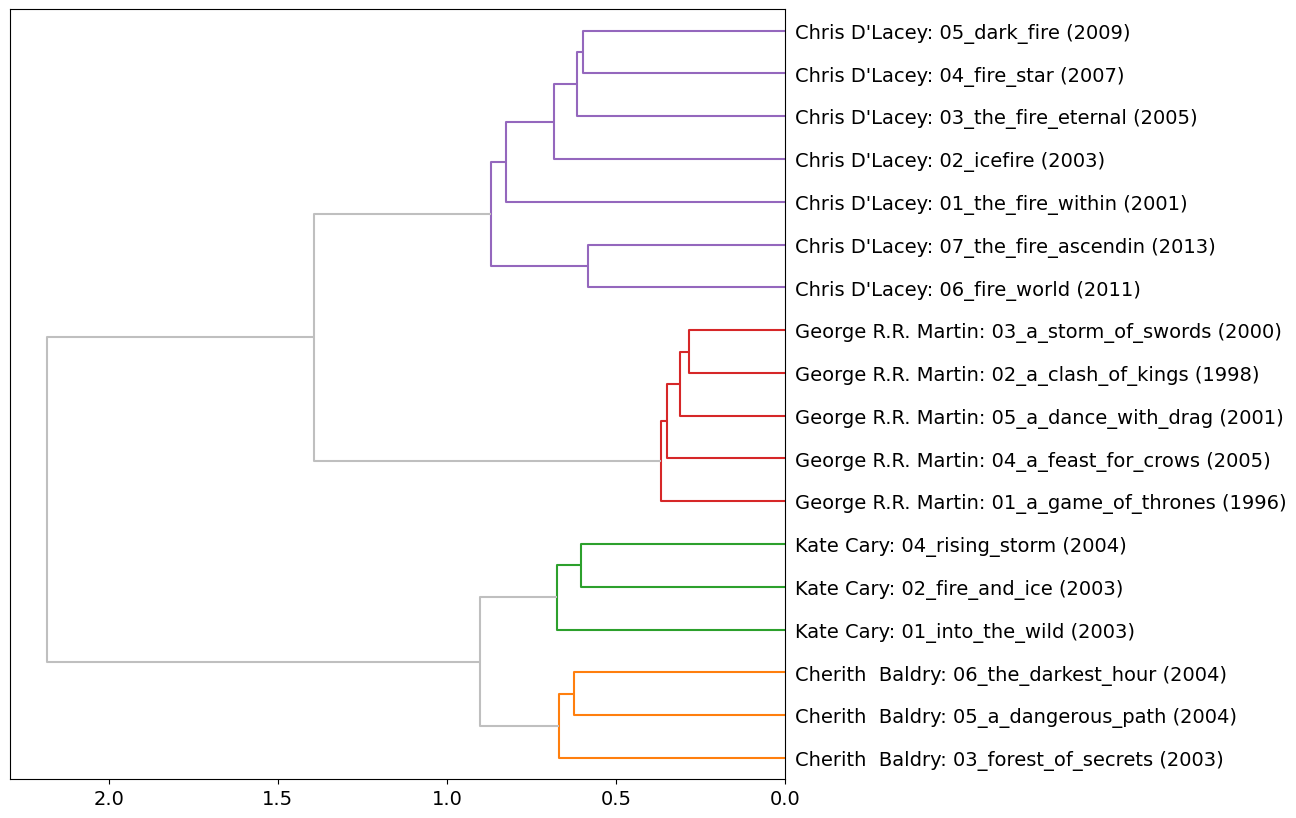

In [34]:
hac(PAIRS['euclidean-ward'], linkage_method='ward', color_thresh=.9)

<Figure size 640x480 with 0 Axes>

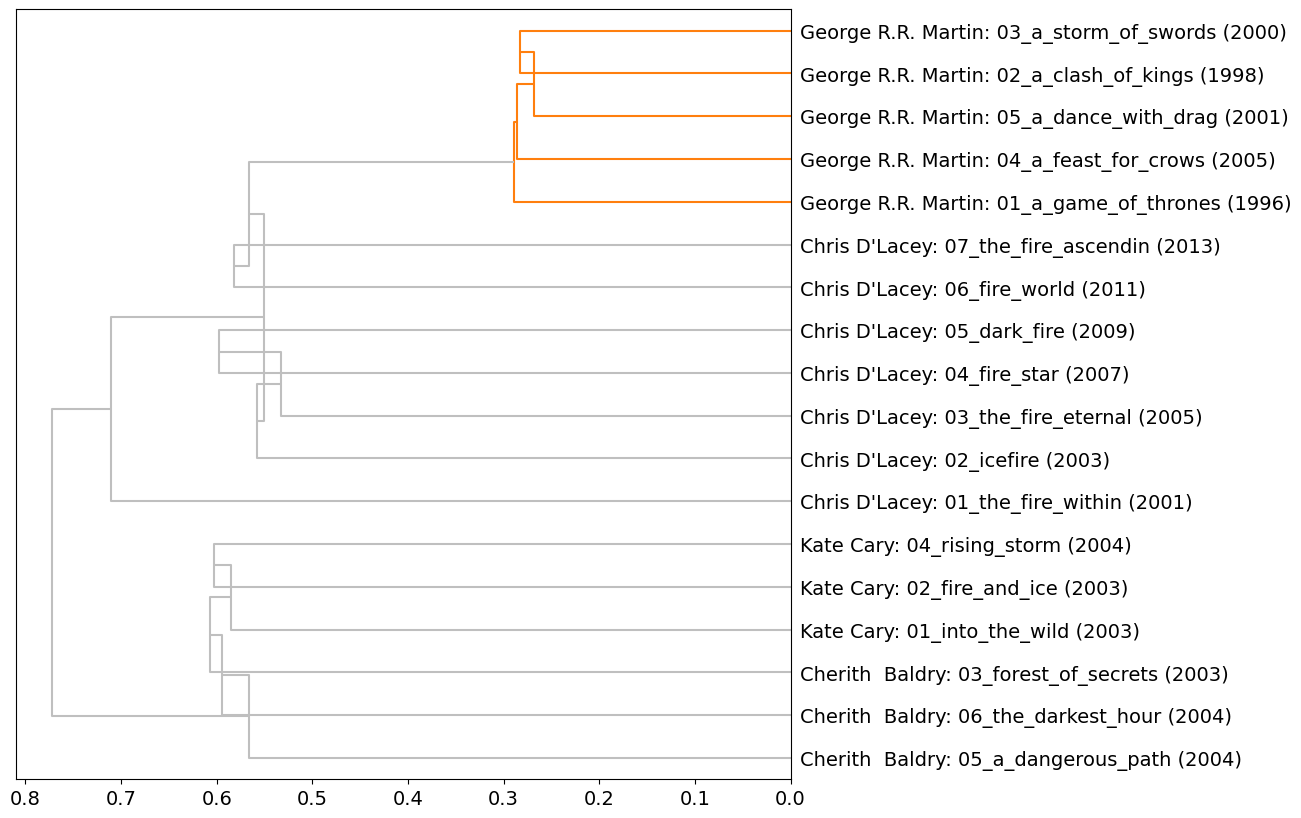

In [35]:
hac(PAIRS['euclidean-centroid'], linkage_method='centroid', color_thresh=.5)

<Figure size 640x480 with 0 Axes>

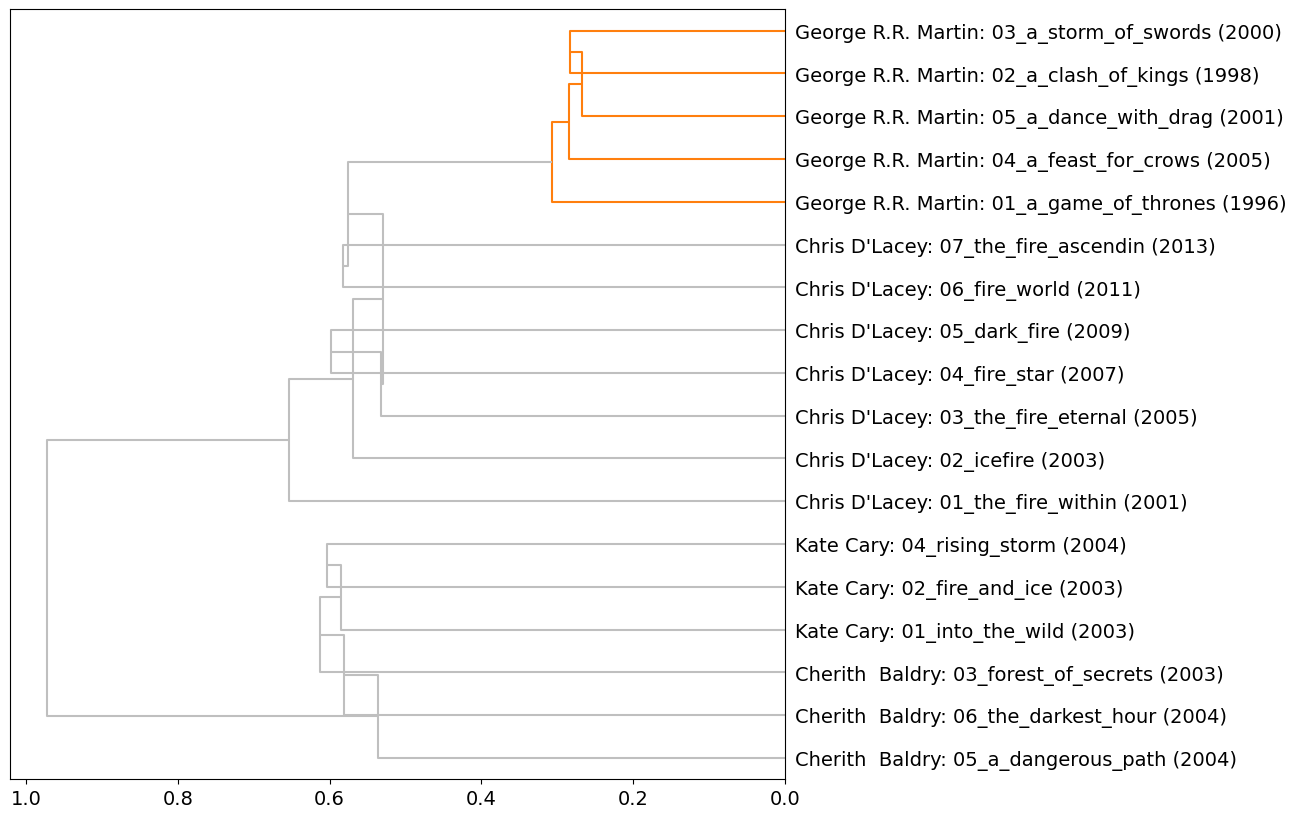

In [36]:
hac(PAIRS['euclidean-median'], linkage_method='median', color_thresh=.5)

### Visualizations: K-Means

In [37]:
from sklearn.cluster import KMeans

In [38]:
def get_k_clusters(k=10, n_init='auto'):
    LIB[f'y_raw_{k}'] = KMeans(k, n_init=n_init).fit_predict(M)
    LIB[f'y_L2_{k}']  = KMeans(k, n_init=n_init).fit_predict(L2)
    y_cols = [col for col in LIB.columns if 'y_' in col and f'_{k}' in col]
    return LIB.reset_index().set_index('label')[y_cols].sort_values('label').style.background_gradient("YlGnBu")

In [39]:
get_k_clusters(3)

,y_raw_3,y_L2_3
label,,
Cherith Baldry: 03_forest_of_secrets (2003),2,0
Cherith Baldry: 05_a_dangerous_path (2004),2,0
Cherith Baldry: 06_the_darkest_hour (2004),2,0
Chris D'Lacey: 01_the_fire_within (2001),1,1
Chris D'Lacey: 02_icefire (2003),1,1
Chris D'Lacey: 03_the_fire_eternal (2005),1,1
Chris D'Lacey: 04_fire_star (2007),1,1
Chris D'Lacey: 05_dark_fire (2009),1,1
Chris D'Lacey: 06_fire_world (2011),1,1


In [40]:
get_k_clusters(4)

,y_raw_4,y_L2_4
label,,
Cherith Baldry: 03_forest_of_secrets (2003),2,2
Cherith Baldry: 05_a_dangerous_path (2004),2,3
Cherith Baldry: 06_the_darkest_hour (2004),2,3
Chris D'Lacey: 01_the_fire_within (2001),0,0
Chris D'Lacey: 02_icefire (2003),0,0
Chris D'Lacey: 03_the_fire_eternal (2005),0,0
Chris D'Lacey: 04_fire_star (2007),0,0
Chris D'Lacey: 05_dark_fire (2009),0,0
Chris D'Lacey: 06_fire_world (2011),3,0


In [41]:
LIB.to_csv(f"{output_dir}\\LIB_LABELS.csv")